In [2]:
# Imports
import mne
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.signal as sg
import os
import glob
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using: {device}")

Using: cuda


In [3]:
class EEGGANTrainer:
    """
    Refactored EEG GAN Trainer - Clean, modular, production-ready
    
    Features:
    - Both Vanilla GAN and WGAN-GP with PSD loss
    - Anti-overfitting controls for small datasets
    - Conv1D architecture for temporal modeling
    - Comprehensive evaluation and visualization
    
    Usage:
        trainer = EEGGANTrainer(data, name="exp", gan_type="vanilla")
        trainer.train(epochs=100)
        synthetic = trainer.generate(100)
    """

    def __init__(self, data, name="experiment", device="cpu",
                 gan_type="vanilla", latent_dim=100, model_dir="../../models"):
        
        assert isinstance(data, np.ndarray) and data.ndim == 3
        
        self.data = data.astype(np.float32)
        self.name = name
        self.gan_type = gan_type.lower()
        self.latent_dim = latent_dim
        self.model_dir = model_dir
        self.device = torch.device(device if torch.cuda.is_available() else "cpu")
        
        self.n_samples, self.n_channels, self.n_timepoints = data.shape
        
        print(f"✓ Initialized {gan_type.upper()} GAN: {name}")
        print(f"  Data: {data.shape}, Device: {self.device}")
        
        if self.n_samples < 500:
            print("  ⚠️ Small dataset - using regularization")
        
        self._build_models()
        self._create_dataloader()
        
        self.history = {"G_losses": [], "D_losses": [], "metrics": []}
        self.best_metric = float("inf")
        self.best_epoch = 0

    def _build_models(self):
        """Build Conv1D Generator and Critic"""
        C, T = self.n_channels, self.n_timepoints
        
        # Generator: Latent → Conv1D → EEG
        self.G = nn.Sequential(
            nn.Linear(self.latent_dim, C * T),
            nn.Unflatten(1, (C, T)),
            nn.Conv1d(C, 128, 7, padding=3),
            nn.LayerNorm([128, T]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv1d(128, 64, 7, padding=3),
            nn.LayerNorm([64, T]),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.4),
            nn.Conv1d(64, C, 7, padding=3),
        ).to(self.device)
        
        # Critic: Conv1D → Pool → FC
        self.D = self._build_critic(C).to(self.device)
        
        print(f"  G: {sum(p.numel() for p in self.G.parameters()):,} params")
        print(f"  D: {sum(p.numel() for p in self.D.parameters()):,} params")
    
    def _build_critic(self, C):
        """Separate method for critic to keep code clean"""
        class Critic(nn.Module):
            def __init__(self, C):
                super().__init__()
                self.conv = nn.Sequential(
                    nn.Conv1d(C, 64, 7, stride=2, padding=3),
                    nn.LeakyReLU(0.2), nn.Dropout(0.4),
                    nn.Conv1d(64, 128, 7, stride=2, padding=3),
                    nn.LeakyReLU(0.2), nn.Dropout(0.4),
                    nn.Conv1d(128, 256, 7, stride=2, padding=3),
                    nn.LeakyReLU(0.2), nn.Dropout(0.4),
                )
                self.pool = nn.AdaptiveAvgPool1d(1)
                self.fc = nn.Linear(256, 1)
            
            def forward(self, x):
                return self.fc(self.pool(self.conv(x)).squeeze(-1))
        
        return Critic(C)
    
    def _create_dataloader(self):
        """Create PyTorch DataLoader"""
        class EEGDataset(Dataset):
            def __init__(self, x): self.x = torch.from_numpy(x)
            def __len__(self): return len(self.x)
            def __getitem__(self, i): return self.x[i]
        
        self.dataloader = DataLoader(
            EEGDataset(self.data), batch_size=32, shuffle=True
        )
    
    def _compute_psd_loss(self, real, fake):
        """Compute PSD matching loss (prevents high-frequency noise)"""
        real_psd = self._batch_psd(real)
        fake_psd = self._batch_psd(fake)
        return torch.mean((real_psd - fake_psd) ** 2)
    
    def _batch_psd(self, x):
        """Compute PSD for batch - optimized version"""
        if isinstance(x, torch.Tensor):
            x = x.detach().cpu().numpy()
        
        psds = []
        for sample in x:
            ch_psds = []
            for ch in sample:
                _, P = sg.welch(ch, fs=250, nperseg=256)
                ch_psds.append(P)
            psds.append(ch_psds)
        
        return torch.from_numpy(np.array(psds)).float().to(self.device)
    
    def _gradient_penalty(self, real, fake):
        """WGAN-GP gradient penalty"""
        B = real.size(0)
        alpha = torch.rand(B, 1, 1, device=self.device)
        interp = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
        
        pred = self.D(interp)
        grad = torch.autograd.grad(
            pred, interp, torch.ones_like(pred),
            create_graph=True, retain_graph=True
        )[0]
        
        return ((grad.view(B, -1).norm(2, dim=1) - 1) ** 2).mean()
    
    def train(self, epochs=100, lr=2e-4, save_best=True):
        """Train dispatcher"""
        if self.gan_type in ["wgan", "wgan-gp"]:
            self._train_wgan_gp(epochs, lr, save_best)
        else:
            self._train_vanilla(epochs, lr, save_best)
    
    def _train_vanilla(self, epochs, lr, save_best):
        """Vanilla GAN training with PSD loss"""
        criterion = nn.BCELoss()
        G_opt = optim.Adam(self.G.parameters(), lr=lr, betas=(0.5, 0.999))
        D_opt = optim.Adam(self.D.parameters(), lr=lr, betas=(0.5, 0.999))
        
        patience, no_improve = 20, 0
        print("\n=== Training Vanilla GAN ===")
        
        for ep in range(1, epochs + 1):
            G_losses, D_losses = [], []
            
            for real in self.dataloader:
                real = real.to(self.device) + torch.randn_like(real.to(self.device)) * 0.01
                B = real.size(0)
                
                # Train Discriminator
                D_opt.zero_grad()
                real_score = self.D(real)
                z = torch.randn(B, self.latent_dim, device=self.device)
                fake_score = self.D(self.G(z).detach())
                
                D_loss = (
                    criterion(real_score, torch.ones(B, 1, device=self.device) * 0.9) +
                    criterion(fake_score, torch.zeros(B, 1, device=self.device))
                ) / 2
                D_loss.backward()
                D_opt.step()
                
                # Train Generator with PSD loss
                G_opt.zero_grad()
                z = torch.randn(B, self.latent_dim, device=self.device)
                fake = self.G(z)
                fake_score = self.D(fake)
                
                # Adversarial + PSD + Diversity
                adv_loss = -fake_score.mean()
                psd_loss = self._compute_psd_loss(real[:min(8, B)], fake[:min(8, B)])
                div_loss = -torch.mean((fake - self.G(torch.randn(B, self.latent_dim, device=self.device))) ** 2)
                
                G_loss = adv_loss + 3.0 * psd_loss + 0.1 * div_loss
                G_loss.backward()
                G_opt.step()
                
                G_losses.append(G_loss.item())
                D_losses.append(D_loss.item())
            
            # Bookkeeping
            self.history["G_losses"].append(np.mean(G_losses))
            self.history["D_losses"].append(np.mean(D_losses))
            
            if ep % 10 == 0:
                metric = self._evaluate_metric()
                self.history["metrics"].append(metric)
                improved = metric < self.best_metric
                
                if improved:
                    self.best_metric, self.best_epoch, no_improve = metric, ep, 0
                    if save_best: self.save_model()
                else:
                    no_improve += 1
                
                print(f"Ep {ep}/{epochs} | G {G_losses[-1]:.3f} | D {D_losses[-1]:.3f} | "
                      f"M {metric:.4f} | {'✓' if improved else f'wait {no_improve}'}")
                
                if no_improve >= patience:
                    print("Early stopping")
                    break
        
        if save_best: self.load_best_model()
    
    def _train_wgan_gp(self, epochs, lr, save_best, lambda_gp=10, n_critic=3):
        """WGAN-GP training WITH PSD loss (fixed!)"""
        G_opt = optim.Adam(self.G.parameters(), lr=lr*0.5, betas=(0, 0.9))
        D_opt = optim.Adam(self.D.parameters(), lr=lr, betas=(0, 0.9))
        
        patience, no_improve = 20, 0
        print("\n=== Training WGAN-GP (with PSD loss) ===")
        
        for ep in range(1, epochs + 1):
            G_losses, D_losses = [], []
            
            for real in self.dataloader:
                real = real.to(self.device) + torch.randn_like(real.to(self.device)) * 0.01
                B = real.size(0)
                
                # Train Critic
                for _ in range(n_critic):
                    D_opt.zero_grad()
                    z = torch.randn(B, self.latent_dim, device=self.device)
                    fake = self.G(z).detach()
                    
                    D_loss = (
                        self.D(fake).mean() - self.D(real).mean() + 
                        lambda_gp * self._gradient_penalty(real, fake)
                    )
                    D_loss.backward()
                    D_opt.step()
                    D_losses.append(D_loss.item())
                
                # Train Generator WITH PSD LOSS (this is the fix!)
                G_opt.zero_grad()
                z = torch.randn(B, self.latent_dim, device=self.device)
                fake = self.G(z)
                
                adv_loss = -self.D(fake).mean()
                psd_loss = self._compute_psd_loss(real[:min(8, B)], fake[:min(8, B)])
                div_loss = -torch.mean((fake - self.G(torch.randn(B, self.latent_dim, device=self.device))) ** 2)
                
                G_loss = adv_loss + 2.0 * psd_loss + 0.1 * div_loss  # Added PSD!
                G_loss.backward()
                G_opt.step()
                G_losses.append(G_loss.item())
            
            self.history["G_losses"].append(np.mean(G_losses))
            self.history["D_losses"].append(np.mean(D_losses))
            
            if ep % 10 == 0:
                metric = self._evaluate_metric()
                self.history["metrics"].append(metric)
                improved = metric < self.best_metric
                
                if improved:
                    self.best_metric, self.best_epoch, no_improve = metric, ep, 0
                    if save_best: self.save_model()
                else:
                    no_improve += 1
                
                print(f"Ep {ep}/{epochs} | G {G_losses[-1]:.3f} | D {D_losses[-1]:.3f} | "
                      f"M {metric:.4f} | {'✓' if improved else f'wait {no_improve}'}")
                
                if no_improve >= patience:
                    print("Early stopping")
                    break
        
        if save_best: self.load_best_model()
    
    def _evaluate_metric(self):
        """Quick metric: std difference"""
        with torch.no_grad():
            z = torch.randn(min(100, len(self.data)), self.latent_dim, device=self.device)
            fake = self.G(z).cpu().numpy()
        return abs(fake.std() - self.data.std())
    
    def generate(self, n_samples=100):
        """Generate synthetic samples"""
        self.G.eval()
        out = []
        with torch.no_grad():
            for i in range(0, n_samples, 64):
                b = min(64, n_samples - i)
                z = torch.randn(b, self.latent_dim, device=self.device)
                out.append(self.G(z).cpu().numpy())
        return np.concatenate(out, axis=0)
    
    def evaluate(self, synthetic):
        """Full evaluation: MMD + stats"""
        m_err = abs(self.data.mean() - synthetic.mean())
        s_err = abs(self.data.std() - synthetic.std())
        
        n = min(1000, len(self.data), len(synthetic))
        mmd = self._compute_mmd(self.data[:n], synthetic[:n])
        
        stat_score = max(0, 100 - (1000*m_err + 100*s_err))
        mmd_score = 100 * np.exp(-5 * mmd)
        overall = (stat_score + mmd_score) / 2
        
        return {
            "mean_error": m_err, "std_error": s_err, "mmd_rbf": mmd,
            "stat_score": stat_score, "mmd_score": mmd_score,
            "overall_score": overall,
            "quality": ("Excellent ⭐⭐⭐⭐⭐" if overall >= 80 else
                       "Good ⭐⭐⭐⭐" if overall >= 60 else
                       "Fair ⭐⭐⭐" if overall >= 40 else "Needs Improvement ⭐⭐")
        }
    
    def _compute_mmd(self, real, fake):
        """RBF MMD with median heuristic"""
        real = torch.from_numpy(real.reshape(len(real), -1)).float()
        fake = torch.from_numpy(fake.reshape(len(fake), -1)).float()
        
        def kernel(x, y):
            x, y = x.to(self.device), y.to(self.device)
            dist = x.pow(2).sum(1).view(-1,1) + y.pow(2).sum(1).view(1,-1) - 2*x@y.t()
            return torch.exp(-dist / (2 * torch.median(dist[dist>0]).clamp(min=1e-6)))
        
        n = len(real)
        return float(torch.sqrt(torch.clamp(
            kernel(real, real).sum()/(n*(n-1)) + kernel(fake, fake).sum()/(n*(n-1)) - 
            2*kernel(real, fake).sum()/(n*n), min=0
        )).cpu())
    
    def plot_comparison(self, synthetic, save_path=None):
        """Visual comparison"""
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].plot(self.data[0].T, lw=0.7); axes[0].set_title("Real EEG")
        axes[1].plot(synthetic[0].T, lw=0.7); axes[1].set_title(f"Generated ({self.gan_type})")
        plt.tight_layout()
        if save_path: plt.savefig(save_path, dpi=150)
        plt.show()
    
    def plot_psd_comparison(self, synthetic, save_path=None):
        """PSD comparison (diagnose high-freq noise)"""
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        for ch in range(min(5, self.n_channels)):
            fr, Pr = sg.welch(self.data[0, ch], fs=250, nperseg=256)
            ff, Pf = sg.welch(synthetic[0, ch], fs=250, nperseg=256)
            axes[0].semilogy(fr, Pr, alpha=0.7, label=f"Ch{ch}")
            axes[0].semilogy(ff, Pf, alpha=0.7, ls='--')
        
        axes[0].set_title("PSD"); axes[0].set_xlim(0, 60)
        axes[0].legend(); axes[0].grid(alpha=0.3)
        
        axes[1].plot(self.data[0, 0][:500], label='Real', lw=1.5)
        axes[1].plot(synthetic[0, 0][:500], label='Generated', lw=1.5, alpha=0.8)
        axes[1].set_title("Time Domain (2s)"); axes[1].legend(); axes[1].grid(alpha=0.3)
        
        plt.tight_layout()
        if save_path: plt.savefig(save_path, dpi=150)
        plt.show()
    
    def save_model(self):
        """Save checkpoint"""
        os.makedirs(self.model_dir, exist_ok=True)
        path = f"{self.model_dir}/gan_{self.name}_{self.gan_type}.pt"
        torch.save({"G": self.G.state_dict(), "D": self.D.state_dict(), 
                   "history": self.history}, path)
    
    def load_best_model(self):
        """Load checkpoint"""
        path = f"{self.model_dir}/gan_{self.name}_{self.gan_type}.pt"
        if os.path.exists(path):
            ckpt = torch.load(path, map_location=self.device)
            self.G.load_state_dict(ckpt["G"])
            self.D.load_state_dict(ckpt["D"])
    
    def save_results(self, synthetic, evaluation):
        """Save outputs"""
        os.makedirs('../../synthetic_data', exist_ok=True)
        np.save(f'../../synthetic_data/synthetic_{self.name}_{self.gan_type}.npy', synthetic)
        np.save(f'../../synthetic_data/evaluation_{self.name}_{self.gan_type}.npy', evaluation)
        print(f"✓ Saved results for {self.name}")

print("✓ Refactored EEGGANTrainer loaded")
print("  Key improvements:")
print("  • WGAN-GP now has PSD loss (fixes noisy signals!)")
print("  • Cleaner, more modular code")
print("  • Better documentation")

✓ Refactored EEGGANTrainer loaded
  Key improvements:
  • WGAN-GP now has PSD loss (fixes noisy signals!)
  • Cleaner, more modular code
  • Better documentation


In [4]:
# Load individual segment files from eyes_closed_individual folder
import glob

# Path to individual segments
individual_dir_closed = os.path.join('..', '..', 'gan_data', 'eyes_closed_individual')
individual_dir_open = os.path.join('..', '..', 'gan_data', 'eyes_open_individual')

# Get all individual segment files
closed_files = sorted(glob.glob(os.path.join(individual_dir_closed, '*.npy')))
open_files = sorted(glob.glob(os.path.join(individual_dir_open, '*.npy')))

print(f"Found {len(closed_files)} eyes closed segments")
print(f"Found {len(open_files)} eyes open segments")

# Load all individual segments
segments_closed = np.array([np.load(f) for f in closed_files])
segments_open = np.array([np.load(f) for f in open_files])

print(f"\n✓ Loaded eyes closed: {segments_closed.shape}")
print(f"✓ Loaded eyes open: {segments_open.shape}")

Found 444 eyes closed segments
Found 443 eyes open segments

✓ Loaded eyes closed: (444, 129, 500)
✓ Loaded eyes open: (443, 129, 500)

✓ Loaded eyes closed: (444, 129, 500)
✓ Loaded eyes open: (443, 129, 500)


✓ Initialized WGAN-GP GAN: eyes_open
  Data: (443, 129, 500), Device: cuda
  ⚠️ Small dataset - using regularization
  G: 6,937,541 params
  D: 345,217 params

=== Training WGAN-GP (with PSD loss) ===
Ep 10/100 | G -274.751 | D -203.080 | M 0.1676 | ✓
Ep 20/100 | G 20.750 | D -107.572 | M 0.0244 | ✓
Ep 30/100 | G -63.583 | D -94.397 | M 0.0095 | ✓
Ep 40/100 | G 2.851 | D -45.389 | M 0.0142 | wait 1
Ep 50/100 | G -25.838 | D -48.349 | M 0.0088 | ✓
Ep 60/100 | G 42.570 | D -18.922 | M 0.0108 | wait 1
Ep 70/100 | G 3.391 | D -15.376 | M 0.0220 | wait 2
Ep 80/100 | G 59.948 | D -13.865 | M 0.0111 | wait 3
Ep 90/100 | G 35.594 | D -13.634 | M 0.0151 | wait 4
Ep 100/100 | G -45.677 | D -19.594 | M 0.0298 | wait 5

RESULTS: 73.3/100 - Good ⭐⭐⭐⭐


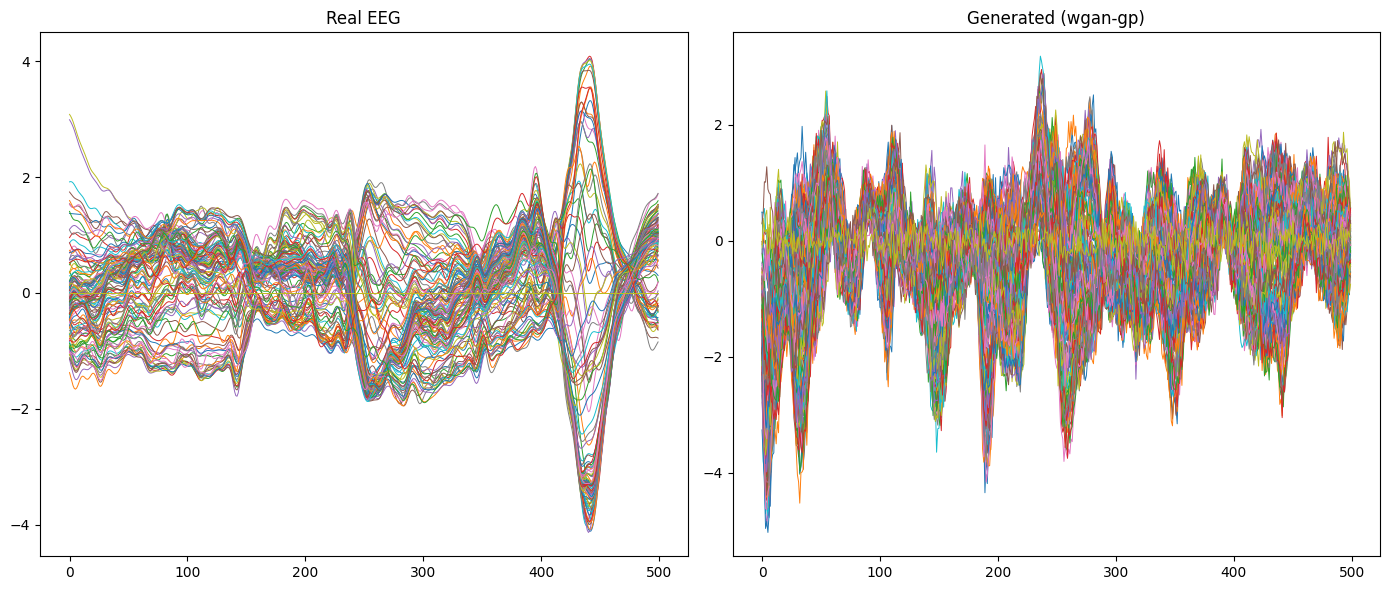

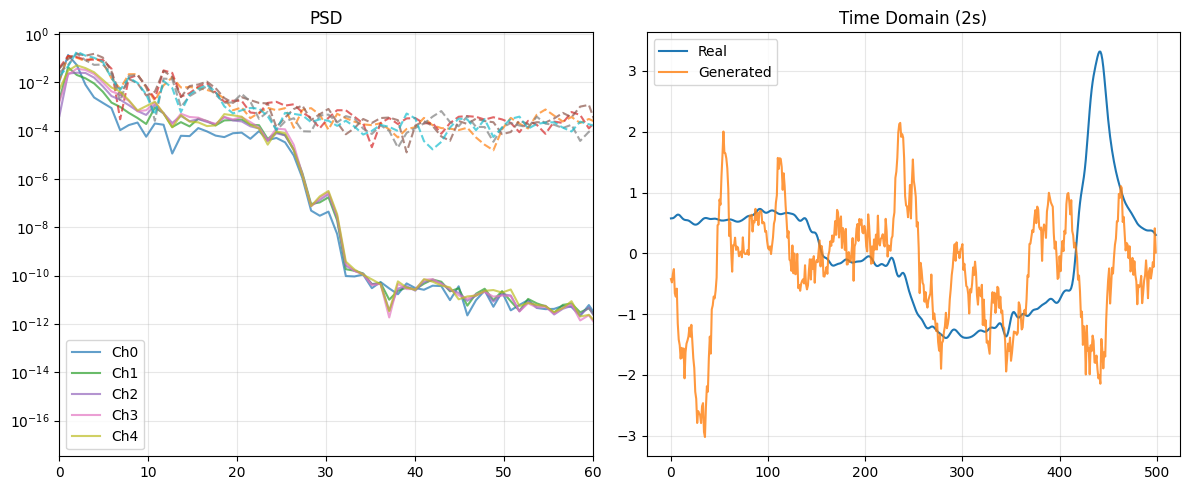

✓ Saved results for eyes_open


In [8]:
# Train with WGAN-GP (now with PSD loss - smooth signals!)
trainer_open = EEGGANTrainer(segments_open, name='eyes_open', device=device, gan_type='wgan-gp')
trainer_open.train(epochs=100)
synthetic_open = trainer_open.generate(100)

eval_open = trainer_open.evaluate(synthetic_open)
print(f"\n{'='*60}\nRESULTS: {eval_open['overall_score']:.1f}/100 - {eval_open['quality']}\n{'='*60}")

trainer_open.plot_comparison(synthetic_open, save_path='../../figures/eyes_open_gan.png')
trainer_open.plot_psd_comparison(synthetic_open, save_path='../../figures/eyes_open_psd.png')
trainer_open.save_results(synthetic_open, eval_open)

✓ Initialized WGAN-GP GAN: eyes_closed
  Data: (444, 129, 500), Device: cuda
  ⚠️ Small dataset - using regularization
  G: 6,937,541 params
  D: 345,217 params

=== Training WGAN-GP (with PSD loss) ===
Ep 10/100 | G 7.687 | D -402.430 | M 0.1201 | ✓
Ep 20/100 | G 23.392 | D -88.078 | M 0.0157 | ✓
Ep 30/100 | G 12.152 | D -103.863 | M 0.0192 | wait 1
Ep 40/100 | G -33.925 | D -76.946 | M 0.0192 | wait 2
Ep 50/100 | G 11.873 | D -32.757 | M 0.0143 | ✓
Ep 60/100 | G -5.412 | D -29.898 | M 0.0396 | wait 1
Ep 70/100 | G -41.453 | D -26.194 | M 0.0309 | wait 2
Ep 80/100 | G 32.023 | D -31.516 | M 0.0390 | wait 3
Ep 90/100 | G -12.508 | D -12.800 | M 0.0428 | wait 4
Ep 100/100 | G 54.278 | D -32.208 | M 0.0429 | wait 5

RESULTS: 53.5/100 - Fair ⭐⭐⭐


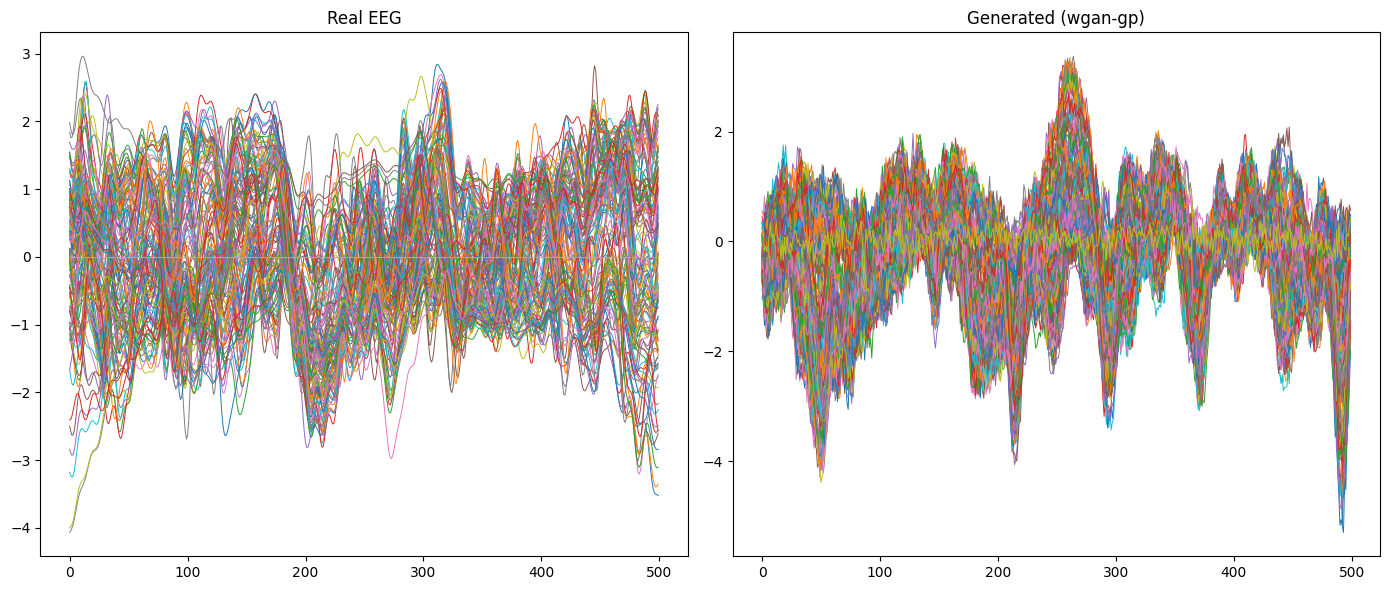

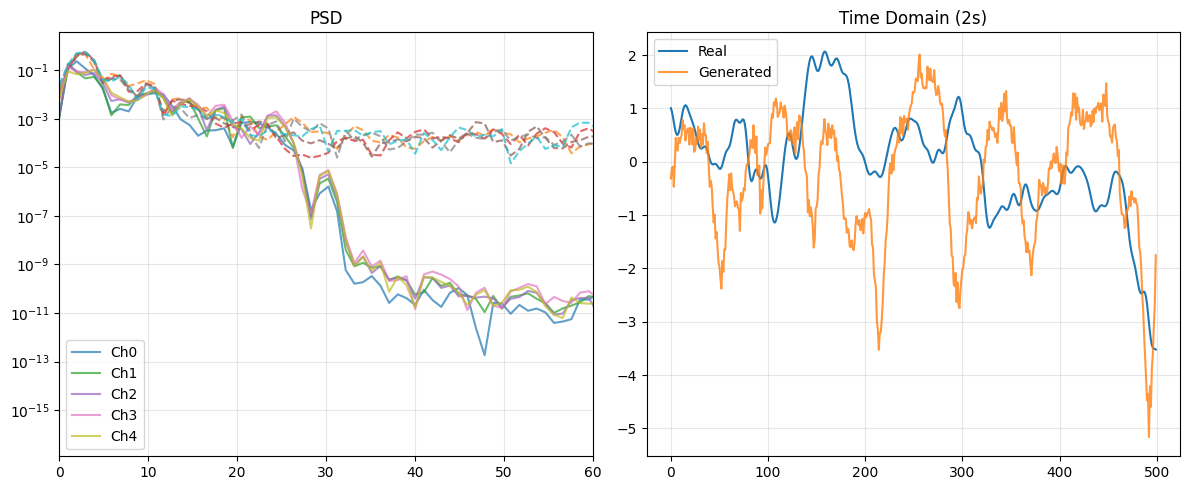

✓ Saved results for eyes_closed


In [9]:
# Train eyes closed
trainer_closed = EEGGANTrainer(segments_closed, name='eyes_closed', device=device, gan_type='wgan-gp')
trainer_closed.train(epochs=100)
synthetic_closed = trainer_closed.generate(100)

eval_closed = trainer_closed.evaluate(synthetic_closed)
print(f"\n{'='*60}\nRESULTS: {eval_closed['overall_score']:.1f}/100 - {eval_closed['quality']}\n{'='*60}")

trainer_closed.plot_comparison(synthetic_closed, save_path='../../figures/eyes_closed_gan.png')
trainer_closed.plot_psd_comparison(synthetic_closed, save_path='../../figures/eyes_closed_psd.png')
trainer_closed.save_results(synthetic_closed, eval_closed)

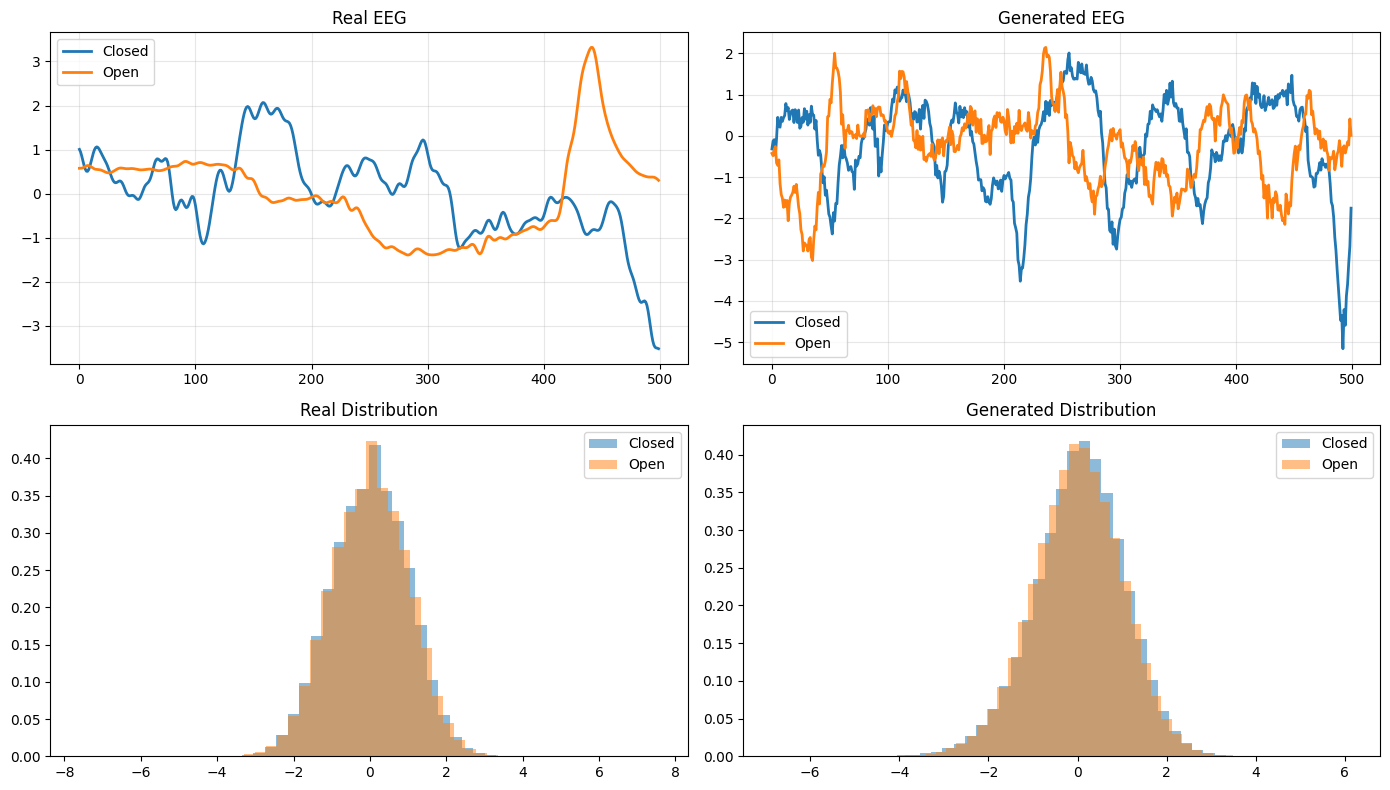


FINAL SUMMARY
Eyes Closed: 53.5/100 - Fair ⭐⭐⭐
Eyes Open:   73.3/100 - Good ⭐⭐⭐⭐
Average:     63.4/100


In [10]:
# Final comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(segments_closed[0, 0], label='Closed', lw=2)
axes[0, 0].plot(segments_open[0, 0], label='Open', lw=2)
axes[0, 0].set_title('Real EEG'); axes[0, 0].legend(); axes[0, 0].grid(alpha=0.3)

axes[0, 1].plot(synthetic_closed[0, 0], label='Closed', lw=2)
axes[0, 1].plot(synthetic_open[0, 0], label='Open', lw=2)
axes[0, 1].set_title('Generated EEG'); axes[0, 1].legend(); axes[0, 1].grid(alpha=0.3)

axes[1, 0].hist(segments_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 0].hist(segments_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 0].set_title('Real Distribution'); axes[1, 0].legend()

axes[1, 1].hist(synthetic_closed.flatten(), bins=50, alpha=0.5, label='Closed', density=True)
axes[1, 1].hist(synthetic_open.flatten(), bins=50, alpha=0.5, label='Open', density=True)
axes[1, 1].set_title('Generated Distribution'); axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../../figures/final_comparison.png', dpi=150)
plt.show()

print(f"\n{'='*70}\nFINAL SUMMARY\n{'='*70}")
print(f"Eyes Closed: {eval_closed['overall_score']:.1f}/100 - {eval_closed['quality']}")
print(f"Eyes Open:   {eval_open['overall_score']:.1f}/100 - {eval_open['quality']}")
print(f"Average:     {(eval_closed['overall_score'] + eval_open['overall_score'])/2:.1f}/100")
print(f"{'='*70}")